<a href="https://www.linkedin.com/in/hern%C3%A1n-contigiani-41260679/"><img src="https://raw.githubusercontent.com/hernancontigiani/tf_certification/main/images/hc_banner.png" width="1000" align="center"></a>


# Tensorflow Developer Certification

Classification practice\
Extra: Normalization layers inside model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

In [ ]:
!wget https://raw.githubusercontent.com/hernancontigiani/tf_certification/main/utils_tf.py
from utils_tf import *

--2021-12-22 00:13:27--  https://raw.githubusercontent.com/hernancontigiani/tf_certification/main/utils_tf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10220 (10.0K) [text/plain]
Saving to: ‘utils_tf.py’

utils_tf.py         100%[===================>]   9.98K  --.-KB/s    in 0s      

2021-12-22 00:13:27 (65.0 MB/s) - ‘utils_tf.py’ saved [10220/10220]



In [ ]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
df = pd.read_csv(csv_file)

In [ ]:
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [ ]:
df["AdoptionSpeed"].value_counts()

2    3153
4    3080
3    2543
1    2432
0     329
Name: AdoptionSpeed, dtype: int64

In [ ]:
# 0: not addopted, 1: addopted
df["target"] = df["AdoptionSpeed"].apply(lambda x: 0 if x==4 else 1)
df["target"].value_counts()

1    8457
0    3080
Name: target, dtype: int64

In [ ]:
# Drop un-used columns.
df = df.drop(columns=['AdoptionSpeed', 'Description'])

In [ ]:
text_columns = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

In [ ]:
for col in text_columns:
    print(f"Col {col} has {len(df[col].unique())}")

Col Type has 2
Col Color1 has 7
Col Color2 has 7
Col Gender has 2
Col MaturitySize has 3
Col FurLength has 3
Col Vaccinated has 3
Col Sterilized has 3
Col Health has 3
Col Breed1 has 166


In [ ]:
# Breed is to large for categorical
categorical_columns = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health']

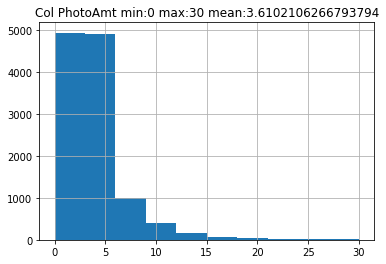

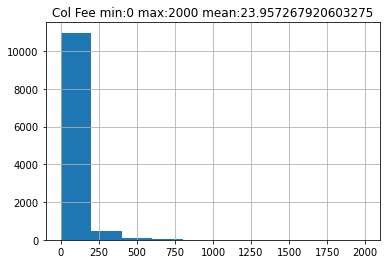

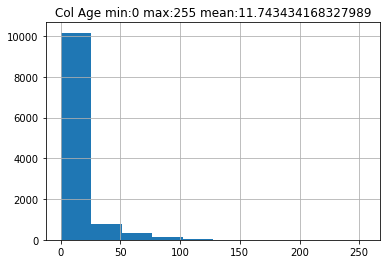

In [ ]:
num_columns = ['PhotoAmt', 'Fee', 'Age']
for col in num_columns:
    plt.figure()
    plt.title(f"Col {col} min:{df[col].min()} max:{df[col].max()} mean:{df[col].mean()}")
    df[col].hist()

plt.show()

### Dataset

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [ ]:
batch_size = 32

train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### Crear featureColumn with normalization

In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/feature_columns

In [ ]:
def get_normalization_parameters(traindf, features):
    """Get the normalization parameters (E.g., mean, std) for traindf for 
    features. We will use these parameters for training, eval, and serving."""

    def _z_score_params(column):
        mean = traindf[column].mean()
        std = traindf[column].std()
        return {'mean': mean, 'std': std}

    normalization_parameters = {}
    for column in features:
        normalization_parameters[column] = _z_score_params(column)
    return normalization_parameters

normalization_parameters = get_normalization_parameters(df, num_columns)

In [ ]:
normalization_parameters

{'Age': {'mean': 11.743434168327989, 'std': 19.324220547073008},
 'Fee': {'mean': 23.957267920603275, 'std': 80.02422588130023},
 'PhotoAmt': {'mean': 3.6102106266793794, 'std': 3.1458715927437386}}

In [ ]:

def _numeric_column_normalized(column_name, normalizer_fn):
    return tf.feature_column.numeric_column(column_name, normalizer_fn=normalizer_fn)

# Define your feature columns
def create_feature_cols(features, use_normalization=False, normalization_parameters=[]):
    """Create feature columns using tf.feature_column. 
    
    This function will get executed during training, evaluation, and serving."""
    def normalize_column(col):  # Use mean, std defined below.
        return (col - mean)/std
    normalized_feature_columns = []
    for column_name in features:
        normalizer_fn = None
        if use_normalization:
            column_params = normalization_parameters[column_name]
            mean = column_params['mean']
            std = column_params['std']
            def zscaler(col):  # Use mean, std defined above.
                return (col - mean)/std
            normalizer_fn = zscaler
        normalized_feature_columns.append(_numeric_column_normalized(column_name,
                                                                     normalizer_fn))
    return normalized_feature_columns

feature_columns = create_feature_cols(num_columns, use_normalization=True, normalization_parameters=normalization_parameters)

In [ ]:
from tensorflow import feature_column

feature_columns = []

# numeric cols
for col_name in num_columns:
  feature_columns.append(feature_column.numeric_column(col_name))

# categoricals
for col_name in categorical_columns:
  categorical_col = feature_column.categorical_column_with_vocabulary_list(
      col_name, df[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_col)
  feature_columns.append(indicator_column)

# embedding columns
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', df.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)

In [ ]:
in_shape = train.shape[1]
in_shape

14

In [ ]:
model_1 = tf.keras.Sequential([
    #layers.Input(shape=(in_shape,)),
    tf.keras.layers.DenseFeatures(feature_columns),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1, activation="sigmoid")
])

model_1.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
229/231 [============================>.] - ETA: 0s - loss: 0.7889 - accuracy: 0.7097WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Type': <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=string>, 'Age': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=int64>, 'Breed1': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=string>, 'Gender': <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=string>, 'Color1': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'Color2': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=string>, 'MaturitySize': <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=string>, 'FurLength': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'Vaccinated': <tf.Tensor 'IteratorGetNext:12' shape=(None,) dtype=string>, 'Sterilized': <tf.Tensor 'It

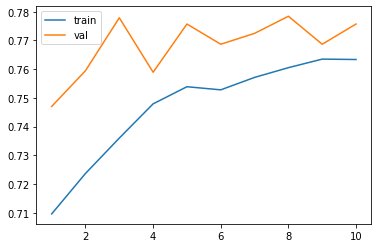

In [ ]:
history_plot(history_1)

In [ ]:
model_1.evaluate(test_ds)

73/73 [==============================] - 0s 5ms/step - loss: 0.5140 - accuracy: 0.7509


[0.5139943957328796, 0.7508665323257446]

In [ ]:
y_hat_prob = model_1.predict(test_ds)
y_hat_prob.shape

Consider rewriting this model with the Functional API.


(2308, 1)

In [ ]:
y_hat = tf.squeeze(tf.round(y_hat_prob)).numpy()
y_hat.shape

(2308,)

In [ ]:
y_test = np.array(unbatch_test_dataset(test_ds))
y_test.shape

(2308,)

In [ ]:
evaluate_classification(y_test, y_hat)

{'accuracy': 0.7508665511265165, 'f1_score': 0.8453053537799301}